In [1]:
import tensorflow as tf
# import preprocessDefinition as preprocess
from matplotlib import pyplot as plt
import pandas as pd

def parse_examples(serialized_examples):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "birdType": tf.io.FixedLenFeature([], tf.int64),
    }
    examples = tf.io.parse_example(serialized_examples, feature_description)
    images = examples.pop("image")
    resized_images = tf.image.resize_with_pad(
        tf.cast(tf.io.decode_jpeg(images, channels=3), tf.float32), 299, 299
    )
    targey_key = list(examples.keys())[0]
    targets = examples[targey_key]
    print()
    print("parse_examples")
    print(tf.shape(resized_images))
    print(tf.shape(targets))
    return resized_images, targets

nToAugment=4
def augmentImages(image,label):
    resized_image = tf.image.resize_with_pad(image,299,299)
    imageL=[resized_image]
    myGen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
    width_shift_range=[-0.2,0.2],height_shift_range=[-.2,.2],
    brightness_range=[.6,1.0], shear_range=0.0,
    channel_shift_range=0.0, fill_mode='constant', cval=0.0, horizontal_flip=True,
    vertical_flip=True)
    augmented_images=[next(myGen.flow(resized_image)) for _ in range(nToAugment)]
    # augmented_images=[next(tf.ensure_shape(myGen.flow(resized_image), (299,299,3))) for _ in range(nToAugment)]
    labels=[label.numpy() for _ in range(nToAugment+1)]
    for i in range(nToAugment):
        augmented_image = tf.ensure_shape(augmented_images[i], (299, 299, 3))
        imageL.append(augmented_image)
    # imageL.extend(augmented_images)
    print()
    print("augmentImages")
    print(tf.shape(imageL))
    print(tf.shape(labels))
    return imageL, labels

def augmentImagesTF(image,label):
    func=tf.py_function(augmentImages,[image,label],[tf.float32,tf.int32])
    return func

def mySqueeze(x,y):
    print()
    print("mySqueeze")
    print(tf.shape(x))
    print(tf.shape(y))
    return tf.squeeze(x),y

def preporc(dataset):
    cnt=1
    plt.figure(figsize=(32,16))
    for inst in dataset.unbatch().take(32):
        plt.subplot(10,10,cnt)
        plt.imshow(inst[0].numpy())
        plt.axis('off')
        plt.title(inst[1][0].numpy())
        cnt=cnt+1

def fixup_shape(images, labels):
    images.set_shape([None, None, 3])
    labels.set_shape([None, 1]) # I have 19 classes
    print()
    print("fixup_shape")
    print(tf.shape(images))
    print(tf.shape(labels))
    return images, labels

In [12]:
train_raw_dataset = tf.data.TFRecordDataset(["./datasets/birds-20-eachOf-358.tfrecords"])
valid_raw_dataset = tf.data.TFRecordDataset(["./datasets/birds-10-eachOf-358.tfrecords"])

# train_dataset = train_raw_dataset.map(parse_examples, num_parallel_calls=tf.data.AUTOTUNE).batch(1).map(augmentImagesTF,num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.map(mySqueeze, num_parallel_calls=tf.data.AUTOTUNE).map(fixup_shape, num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.map(lambda image,label: (tf.keras.applications.xception.preprocess_input(image), label), num_parallel_calls=tf.data.AUTOTUNE).batch(32)

train_dataset = train_raw_dataset.map(parse_examples, num_parallel_calls=2).map(lambda image,label: (tf.keras.applications.xception.preprocess_input(image), label), num_parallel_calls=2).batch(32)
valid_dataset = valid_raw_dataset.map(parse_examples, num_parallel_calls=2).map(lambda image,label: (tf.keras.applications.xception.preprocess_input(image), label), num_parallel_calls=2).batch(32)

# Model Creation
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(358, activation="softmax")(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer.trainable)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('birdsVsSquirrelsModel', save_best_only=True)
earlyStop_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
ss=5e-1
optimizer = tf.keras.optimizers.SGD(learning_rate=ss)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


parse_examples
Tensor("Shape:0", shape=(3,), dtype=int32)
Tensor("Shape_1:0", shape=(0,), dtype=int32)

parse_examples
Tensor("Shape:0", shape=(3,), dtype=int32)
Tensor("Shape_1:0", shape=(0,), dtype=int32)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_6[0][0]']                
                                32)                                                               
                                                                                  

In [ ]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=1, callbacks=[checkpoint_cb, earlyStop_cb])

In [3]:
# print("train")
for el in train_dataset.take(2):
    print(tf.shape(el[0]))
    print(tf.shape(el[1]))

# print()
# print("valid")
# for el in valid_dataset.take(2):
#     print(el)

2023-05-12 21:09:31.057306: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
model.save('birdsVsSquirrelsModel')

INFO:tensorflow:Assets written to: birdsVsSquirrelsModel/assets


INFO:tensorflow:Assets written to: birdsVsSquirrelsModel/assets


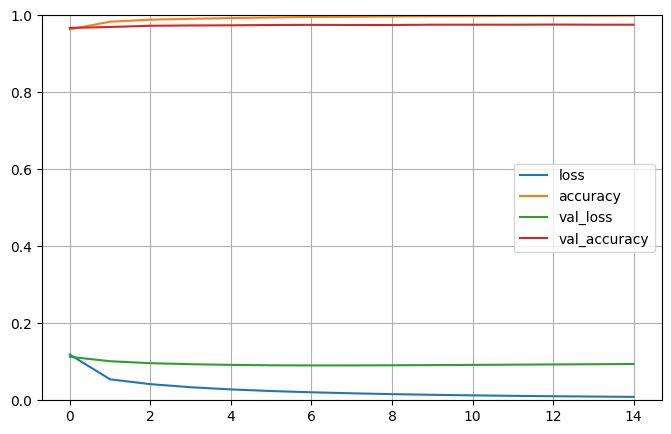

In [ ]:
# Plotting the accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [2]:
import tensorflow as tf

# Model Creation
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(358, activation="softmax")(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer.trainable)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('./new/birdsVsSquirrelsModel', save_best_only=True)
earlyStop_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
ss=5e-1
optimizer = tf.keras.optimizers.SGD(learning_rate=ss)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.save('./new/birdsVsSquirrelsModel')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

INFO:tensorflow:Assets written to: ./new/birdsVsSquirrelsModel/assets


INFO:tensorflow:Assets written to: ./new/birdsVsSquirrelsModel/assets
